# Setting up the modules 

In [1]:
# common libraries
import sys, glob, random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# analysis related modules
from scipy.stats import entropy, spearmanr, describe
from scipy import interp
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, roc_curve, auc
from sklearn.model_selection import KFold, GroupKFold
from collections import Counter

In [3]:
from utils.utils import rmse, rocauc, ci
from tqdm import tqdm_notebook

Using TensorFlow backend.
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [4]:
# some option settings for Jupyter notebook and TF
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_colwidth', -1)
# tf.logging.set_verbosity(tf.logging.ERROR)

# import cloze sentences 

In [5]:
try:
    from google import colab
    IN_COLAB = True
    # mount GoogleDrive for data and external resources
    colab.drive.mount('/content/drive')

    # download and install additional libraries
    !pip install keras_tqdm -q
    !pip install livelossplot -q
    
    
#     sys.path.append('./drive/My Drive/Colab Notebooks')  # append colab directory to Python kernel's path
    df_cloze = pd.read_pickle('./drive/My Drive/Colab Notebooks/dataset/cloze_df_scores_all3.pickle')
except:
    IN_COLAB = False
    df_cloze = pd.read_pickle('./dataset/cloze_df_scores_all3.pickle') # enter the local location of DSCoVAR sentence data

In [6]:
df_cloze.shape

(1783, 28)

In [7]:
mm_scaler = MinMaxScaler()

resp_scores = mm_scaler.fit_transform(df_cloze[['ent_cloze', 
                                                'elmo_score', 'bert_score', 'glove_score',
                                                'scores_sum', 'sent_len']])
resp_lex = resp_scores[:, 0]
resp_lex = 1-resp_lex # reversing the direction: high score for high informative sentences

resp_brt = resp_scores[:, 1]
resp_lmo = resp_scores[:, 2]
resp_glv = resp_scores[:, 3]
resp_bws = resp_scores[:, 4]
sent_len = resp_scores[:, 5]

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


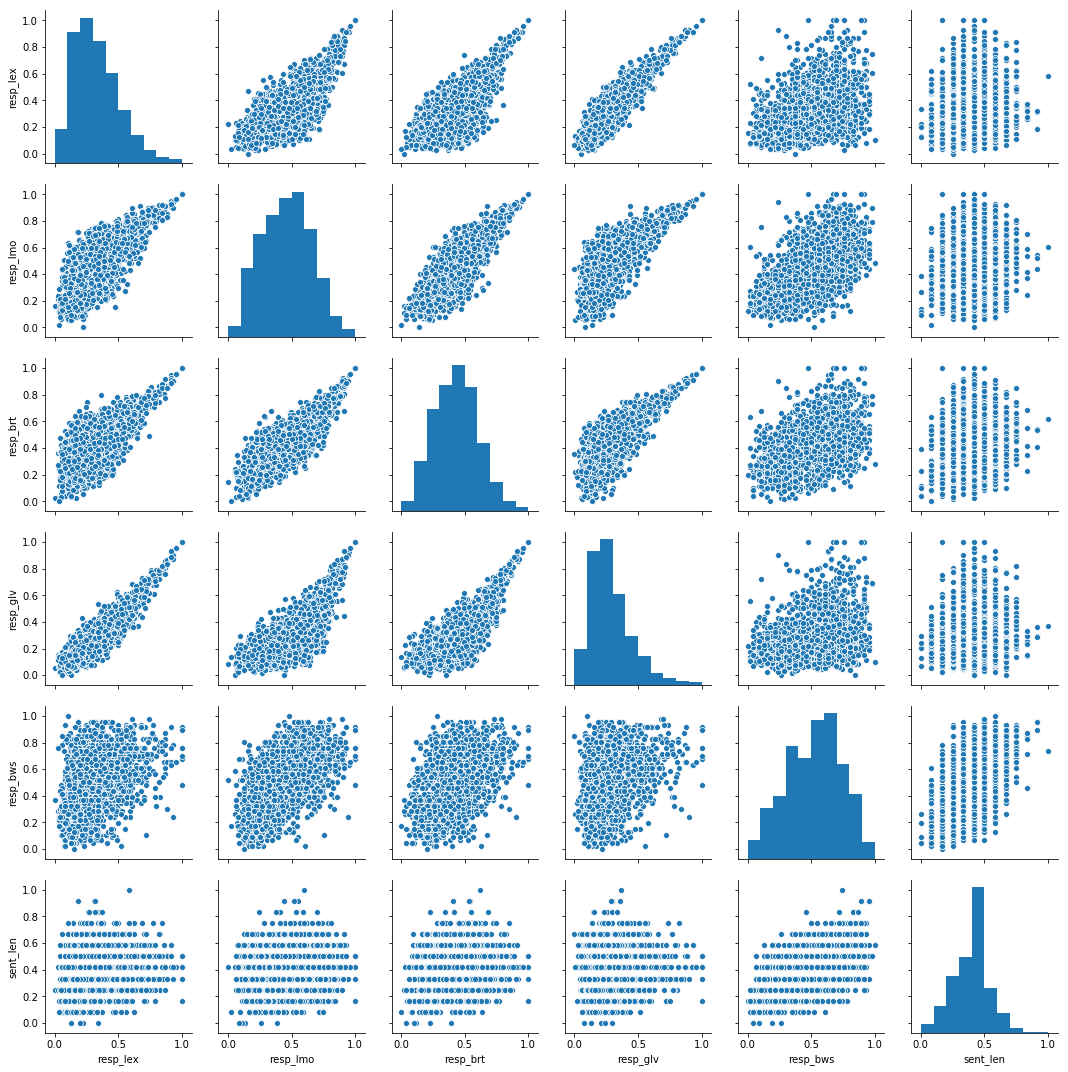

In [8]:
sns.pairplot(pd.DataFrame({"resp_lex":resp_lex, 
                           "resp_lmo":resp_lmo, "resp_brt":resp_brt, "resp_glv":resp_glv, 
                           "resp_bws":resp_bws,
                           "sent_len":sent_len}))

In [9]:
spearmanr(resp_bws, resp_glv)

SpearmanrResult(correlation=0.29171271599311266, pvalue=2.5929076452565018e-36)

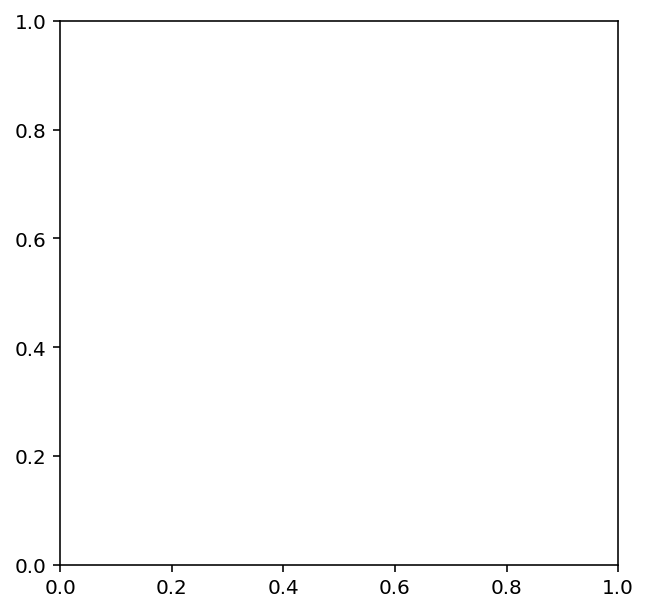

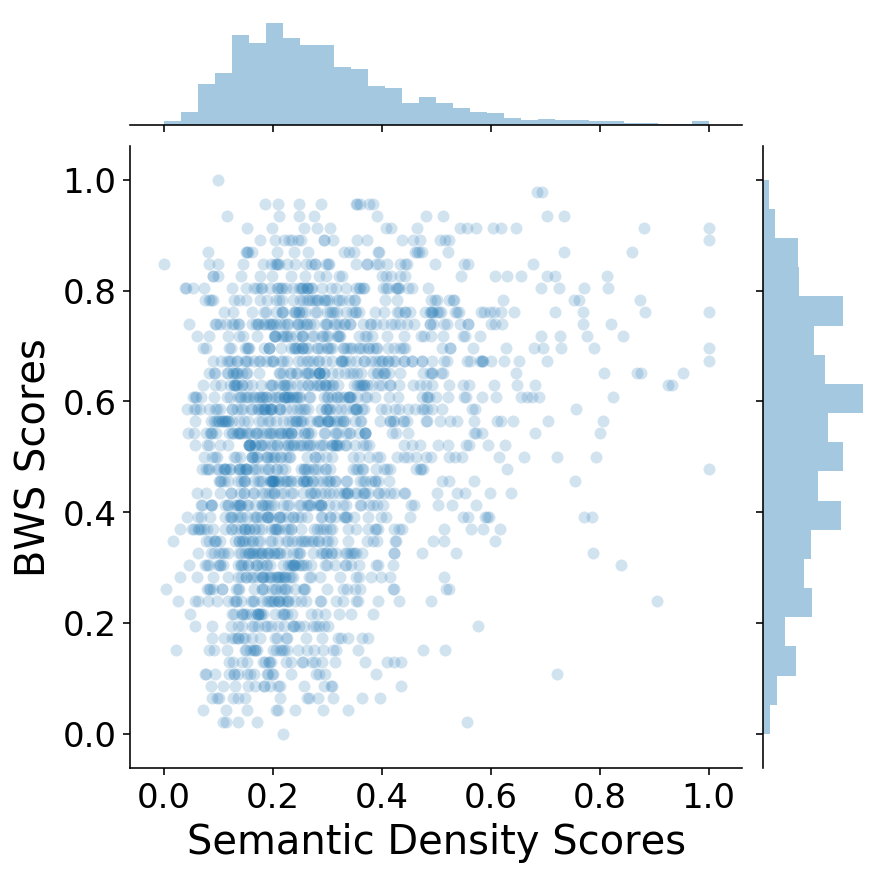

In [10]:
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

tt = pd.DataFrame({"resp_glv":resp_glv, "resp_bws":resp_bws})
g = sns.jointplot(x='resp_glv', y='resp_bws',
              data=tt,
              alpha=0.2, linewidth=0)
g.set_axis_labels('x', 'y', fontsize=20)

# or set labels via the axes objects
g.ax_joint.set_xlabel('Semantic Density Scores')
g.ax_joint.set_ylabel('BWS Scores')

[xtick.label.set_fontsize(17) for xtick in g.ax_joint.xaxis.get_major_ticks()]
[ytick.label.set_fontsize(17) for ytick in g.ax_joint.yaxis.get_major_ticks()]

g.savefig("result1_0_bws_glv.pdf", dpi=300, bbox_inches = 'tight')

In [10]:
gkf = GroupKFold(n_splits=10) ## target words

In [30]:
np.where((resp_bws>0.8) & (resp_glv>0.8))[0]

array([ 190,  235,  969, 1142, 1316, 1562])

In [31]:
df_cloze.iloc[np.where((resp_bws>0.8) & (resp_glv>0.8))[0]]

,Unnamed: 0,index,cloze_resp,sentID_GM,sentence,targ,targ_POS,cloze_resp_len,ent_elmo,ent_cloze,...,scores_avg_rank,elmo_score,sent_len,targ_loc,targ_loc_before,targ_loc_end,targ_loc_rel,syn1,syn2,syn3
190,190,209,"{'rude': 27, 'funny': 1, 'good': 1, 'polite': 1}",{679},Burping at the dinner table is considered ______ in Western cultures .,uncouth,AJ,[30],2.037405,0.434944,...,1716.0,0.944037,12,7,4,False,0.583333,rude,vulgar,uncultivated
235,235,257,"{'rude': 27, 'mean': 1, 'belching': 1, 'dancing': 1}",{4465},"David makes me embarrassed when he is ______ , instead of polite .",uncouth,AJ,[30],2.250260,0.434944,...,1664.0,0.895304,13,7,5,False,0.538462,rude,vulgar,uncultivated
969,969,1086,{'work': 30},{1061},She had to ______ many hours at the restaurant to earn enough money .,travail,VB,[30],2.074875,0.000000,...,1754.0,1.000000,14,3,10,False,0.214286,work,toil,labor
1142,1142,1277,"{'noise': 28, 'racket': 1, 'raucous': 1}",{126},The barks and howls of dogs created too much ______ for us to sleep .,din,NN,[30],2.054217,0.291140,...,1754.0,0.924089,15,9,5,False,0.600000,noise,clamor,NaN
1316,1316,1469,{'quiet': 30},{573},"The neighbors complained about noise, no matter how ______ we were .",reticent,AJ,[30],2.065728,0.000000,...,1738.0,1.000000,13,9,3,False,0.692308,quiet,silent,NaN
1562,1562,1746,"{'quiet': 26, 'silent': 2, 'withdrawn': 1, 'reserved': 1}",{1120},"Tracy was very shy and was usually ______ , rather than talkative .",reticent,AJ,[30],2.166008,0.531304,...,1627.5,0.914998,13,7,5,False,0.538462,quiet,silent,NaN


In [32]:
df_cloze.iloc[1142], resp_bws[1142], resp_glv[1142], 

(Unnamed: 0         1142                                                                    
 index              1277                                                                    
 cloze_resp         {'noise': 28, 'racket': 1, 'raucous': 1}                                
 sentID_GM          {126}                                                                   
 sentence            The barks and howls of dogs created too much ______  for us to sleep . 
 targ               din                                                                     
 targ_POS           NN                                                                      
 cloze_resp_len     [30]                                                                    
 ent_elmo           2.05422                                                                 
 ent_cloze          0.29114                                                                 
 bert_score         0.958354                                          

In [35]:
df_cloze[df_cloze['sentence'].str.contains("We were not able to tell if the man was ")]

,Unnamed: 0,index,cloze_resp,sentID_GM,sentence,targ,targ_POS,cloze_resp_len,ent_elmo,ent_cloze,...,scores_avg_rank,elmo_score,sent_len,targ_loc,targ_loc_before,targ_loc_end,targ_loc_rel,syn1,syn2,syn3
1648,1648,1849,"{'cop': 2, 'their': 2, 'idiot': 2, 'criminal': 2, 'spy': 1, 'pervert': 1, 'liar': 1, 'jerk': 1, 'nut': 1, 'thief': 1, 'homeless': 1, 'girl': 1, 'miser': 1, 'man': 1, 'gay': 1, 'athlete': 1, 'father': 1, 'trustworthy': 1, 'genius': 1, 'imposer': 1, 'client': 1, 'officer': 1, 'farmer': 1, 'employee': 1, 'professional': 1, 'friend': 1}",{525},We were not able to tell if the man was a ______ or not .,recluse,NN,[30],2.268535,3.216358,...,201.0,0.462366,15,11,3,False,0.733333,loner,hermit,outcast


In [36]:
resp_bws[1648], resp_glv[1648], 

(0.2391304347826087, 0.026800467621375557)

# baseline0 - dummy regressor

In [11]:
from sklearn.dummy import DummyRegressor

In [12]:
gkf_split = gkf.split(df_cloze['sentence'], groups=df_cloze['targ'])

res_b0_pred_glv = []
res_b0_true_glv = []
res_b0_pred_bws = []
res_b0_true_bws = []
for train_idx, test_idx in tqdm_notebook(gkf_split, desc='cvfold'):
    train_feat = df_cloze.iloc[train_idx]['sent_len'].values[:, np.newaxis]
    test_feat = df_cloze.iloc[test_idx]['sent_len'].values[:, np.newaxis]
    
    train_true_glv = resp_glv[train_idx]
    train_true_bws = resp_bws[train_idx]
    test_true_glv = resp_glv[test_idx]
    test_true_bws = resp_bws[test_idx]
    
    mod_glv = DummyRegressor(strategy='mean').fit(train_feat, train_true_glv)
    pred_glv = mod_glv.predict(test_feat)
    res_b0_pred_glv.append(pred_glv)
    res_b0_true_glv.append(test_true_glv)
    
    mod_bws = DummyRegressor(strategy='mean').fit(train_feat, train_true_bws)
    pred_bws = mod_glv.predict(test_feat)
    res_b0_pred_bws.append(pred_bws)
    res_b0_true_bws.append(test_true_bws)    

In [44]:
np.save("base_result_0_dummy_glv.npy", [res_b0_true_glv, res_b0_pred_glv])
np.save("base_result_0_dummy_bws.npy", [res_b0_true_bws, res_b0_pred_bws])

In [13]:
(ci([rmse(true, pred) for true, pred in zip(res_b0_true_glv, res_b0_pred_glv)], digits=3),
 ci([1-rocauc(true, pred, 0.2, "low") for true, pred in zip(res_b0_true_glv, res_b0_pred_glv)], digits=3),
 ci([rocauc(true, pred, 0.5, "high") for true, pred in zip(res_b0_true_glv, res_b0_pred_glv)], digits=3),
 ci([rocauc(true, pred, 0.8, "high") for true, pred in zip(res_b0_true_glv, res_b0_pred_glv)], digits=3))

((0.163, 0.151, 0.176), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [14]:
(ci([rmse(true, pred) for true, pred in zip(res_b0_true_bws, res_b0_pred_bws)], digits=3),
 ci([1-rocauc(true, pred, 0.2, "low") for true, pred in zip(res_b0_true_bws, res_b0_pred_bws)], digits=3),
 ci([rocauc(true, pred, 0.5, "high") for true, pred in zip(res_b0_true_bws, res_b0_pred_bws)], digits=3),
 ci([rocauc(true, pred, 0.8, "high") for true, pred in zip(res_b0_true_bws, res_b0_pred_bws)], digits=3))

((0.315, 0.304, 0.326), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

# baseline1 - linear reg:sentence length 

In [46]:
gkf = GroupKFold(n_splits=10) ## target words

In [47]:
# from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

In [48]:
gkf_split = gkf.split(df_cloze['sentence'], groups=df_cloze['targ'])

res_b1_pred_glv = []
res_b1_true_glv = []
res_b1_pred_bws = []
res_b1_true_bws = []
for train_idx, test_idx in tqdm_notebook(gkf_split, desc='cvfold'):
    train_feat = df_cloze.iloc[train_idx]['sent_len'].values[:, np.newaxis]
    test_feat = df_cloze.iloc[test_idx]['sent_len'].values[:, np.newaxis]
    
    train_true_glv = resp_glv[train_idx]
    train_true_bws = resp_bws[train_idx]
    test_true_glv = resp_glv[test_idx]
    test_true_bws = resp_bws[test_idx]
    
    mod_glv = LinearRegression().fit(train_feat, train_true_glv)
    pred_glv = mod_glv.predict(test_feat)
    res_b1_pred_glv.append(pred_glv)
    res_b1_true_glv.append(test_true_glv)
    
    mod_bws = LinearRegression().fit(train_feat, train_true_bws)
    pred_bws = mod_glv.predict(test_feat)
    res_b1_pred_bws.append(pred_bws)
    res_b1_true_bws.append(test_true_bws)    

In [49]:
np.save("base_result_1_sentlen_glv.npy", [res_b1_true_glv, res_b1_pred_glv])
np.save("base_result_1_sentlen_bws.npy", [res_b1_true_bws, res_b1_pred_bws])

In [50]:
(ci([rmse(true, pred) for true, pred in zip(res_b1_true_glv, res_b1_pred_glv)], digits=3),
 ci([1-rocauc(true, pred, 0.2, "low") for true, pred in zip(res_b1_true_glv, res_b1_pred_glv)], digits=3),
 ci([rocauc(true, pred, 0.5, "high") for true, pred in zip(res_b1_true_glv, res_b1_pred_glv)], digits=3),
 ci([rocauc(true, pred, 0.8, "high") for true, pred in zip(res_b1_true_glv, res_b1_pred_glv)], digits=3))

((0.162, 0.149, 0.175),
 (0.572, 0.535, 0.608),
 (0.573, 0.552, 0.595),
 (0.556, 0.515, 0.597))

In [51]:
(ci([rmse(true, pred) for true, pred in zip(res_b1_true_bws, res_b1_pred_bws)], digits=3),
 ci([1-rocauc(true, pred, 0.2, "low") for true, pred in zip(res_b1_true_bws, res_b1_pred_bws)], digits=3),
 ci([rocauc(true, pred, 0.5, "high") for true, pred in zip(res_b1_true_bws, res_b1_pred_bws)], digits=3),
 ci([rocauc(true, pred, 0.8, "high") for true, pred in zip(res_b1_true_bws, res_b1_pred_bws)], digits=3))

((0.308, 0.298, 0.319),
 (0.781, 0.762, 0.799),
 (0.755, 0.736, 0.775),
 (0.749, 0.725, 0.773))

# baseline2 - BoW

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, Ridge

In [53]:
gkf_split = gkf.split(df_cloze['sentence'], groups=df_cloze['targ'])

res_b2_pred_glv = []
res_b2_true_glv = []
res_b2_pred_bws = []
res_b2_true_bws = []
vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=5).fit(df_cloze['sentence'])

for train_idx, test_idx in tqdm_notebook(gkf_split, desc='cvfold'):
    train_feat = vectorizer.transform(df_cloze.iloc[train_idx]['sentence']).toarray()
    test_feat  = vectorizer.transform(df_cloze.iloc[test_idx]['sentence']).toarray()
    
    train_true_glv = resp_glv[train_idx]
    train_true_bws = resp_bws[train_idx]
    test_true_glv = resp_glv[test_idx]
    test_true_bws = resp_bws[test_idx]
    
    mod_glv = Ridge().fit(train_feat, train_true_glv)
    pred_glv = mod_glv.predict(test_feat)
    res_b2_pred_glv.append(pred_glv)
    res_b2_true_glv.append(test_true_glv)
    
    mod_bws = Ridge().fit(train_feat, train_true_bws)
    pred_bws = mod_glv.predict(test_feat)
    res_b2_pred_bws.append(pred_bws)
    res_b2_true_bws.append(test_true_bws)    

In [54]:
np.save("base_result_2_bow_glv.npy", [res_b2_true_glv, res_b2_pred_glv])
np.save("base_result_2_bow_bws.npy", [res_b2_true_bws, res_b2_pred_bws])

In [55]:
(ci([rmse(true, pred) for true, pred in zip(res_b2_true_glv, res_b2_pred_glv)], digits=3),
 ci([1-rocauc(true, pred, 0.2, "low") for true, pred in zip(res_b2_true_glv, res_b2_pred_glv)], digits=3),
 ci([rocauc(true, pred, 0.5, "high") for true, pred in zip(res_b2_true_glv, res_b2_pred_glv)], digits=3),
 ci([rocauc(true, pred, 0.8, "high") for true, pred in zip(res_b2_true_glv, res_b2_pred_glv)], digits=3))

((0.198, 0.183, 0.214),
 (0.556, 0.522, 0.591),
 (0.559, 0.52, 0.597),
 (0.55, 0.507, 0.593))

In [56]:
(ci([rmse(true, pred) for true, pred in zip(res_b2_true_bws, res_b2_pred_bws)], digits=3),
 ci([1-rocauc(true, pred, 0.2, "low") for true, pred in zip(res_b2_true_bws, res_b2_pred_bws)], digits=3),
 ci([rocauc(true, pred, 0.5, "high") for true, pred in zip(res_b2_true_bws, res_b2_pred_bws)], digits=3),
 ci([rocauc(true, pred, 0.8, "high") for true, pred in zip(res_b2_true_bws, res_b2_pred_bws)], digits=3))

((0.321, 0.311, 0.331),
 (0.638, 0.587, 0.689),
 (0.594, 0.542, 0.646),
 (0.598, 0.552, 0.643))

In [57]:
len(vectorizer.get_feature_names())

980